# Getting Started With NLP

This workbook will be exploring the 
[Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started)
competition from Kaggle. The competition provides a set of tweets
from Twitter and asks you to create a model that is capable of determining
whether or not the tweet is about a natural disaster. The data is provided
in CSV format and provides you with the tweet text, the label (whether or
not it is about a natural disaster), the location, and a keyword. 

This is an NLP task, with a classification objective. 
We will explore using an RNN to solve this challenge.

## Exploratory Data Analysis

To start, we will use pandas to load the CSV data and explore the data
we're provided. You can see the description of the data, including the columns
available, and we should a sample of the data.

We also sort the data using `sample` right away as we will be taking 
direct slices of this dataframe later on. 

We also take a count of the unique bodies of text in the dataset
to determine if we may have any duplicates, which it appears we do.
We also look for rows that have no text, which thankfully there are none.

We show the counts for each label, and we appear to have slightly more 0 labels
in this dataset. 

Finally, we create a wordcloud to help give us some insight into what the common
words are in the dataset text corpus.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


,id,keyword,location,text,target
0,1244,blood,"Seattle, WA",@Chambered_Blood Yeah you are! #SpeakingFromEx...,0
1,334,annihilated,NaN,@TomcatArts thus explaining why you were all a...,1
2,6555,injury,NaN,@AdamRubinESPN Familia: arm injury or head case?,1
3,7168,mudslide,London,#GBBO The difference between Paul and Mary my ...,0
4,3980,devastation,Atlanta g.a.,http://t.co/Gxgm1T3W0J From Devastation to Ela...,0


unique text count: 7503
empty text: Series([], Name: count, dtype: int64)


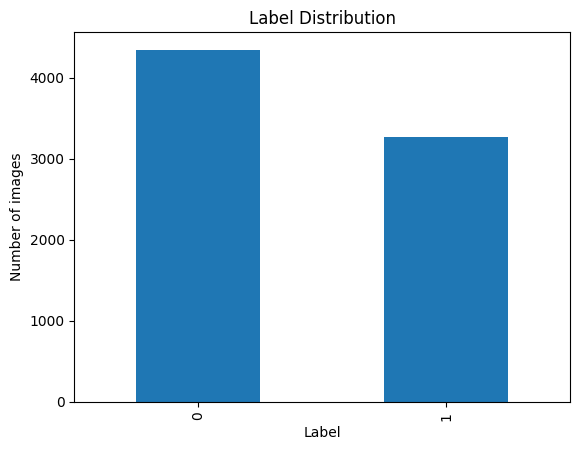

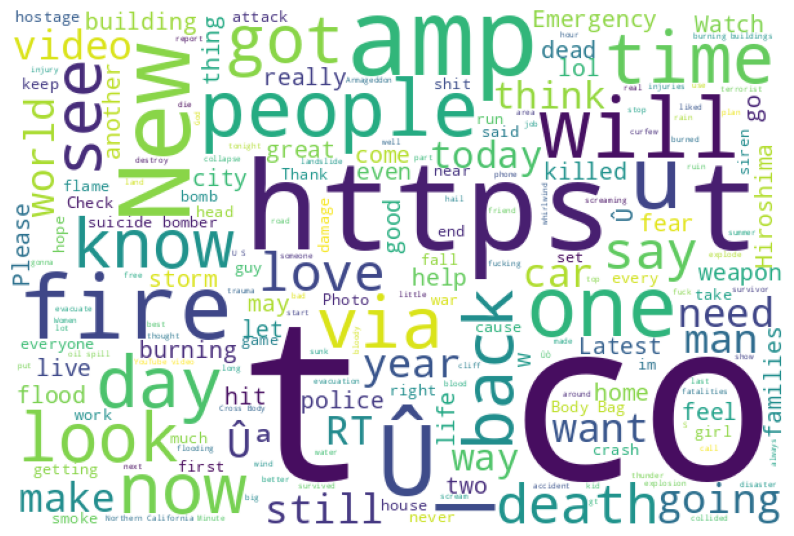

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

base_path = "./nlp-getting-started/"

df = pd.read_csv(base_path + 'train.csv')
df = df.sample(frac=1, random_state=9222).reset_index(drop=True)
df.info()
display(df.head())

print("unique text count:", df.text.value_counts().count())

print("empty text:", df[df.text == ''].value_counts())

df.target.value_counts().plot(kind='bar')
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Number of images')
plt.show()

wordcloud = WordCloud(width=600, height=400, background_color='white')
wordcloud.generate(' '.join(df.text.to_list()))

plt.figure(figsize=(10,15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

We have some data cleanup to do. We will first remove the keyword and location
as we will not be using those in this notebook, and instead will focus only
on the text content of the tweet. We also change the label column from `target` 
to `label` just for convenience sake. 

We can also see above that the tweets contain some mentions and hashtags. We go
ahead and remove the `#` from the hashtags (as they might still contain some text
we want), and we entirely remove mentions as that text data holds no relevance to
solving our task. We also remove URLs as the data seems to contain some `t.co`
URLs.

We then go on to drop duplicates which should remove our duplicate tweets
now that we've dropped our unused columns.

In [2]:
# remove keyword and location
del df['keyword']
del df['location']

# rename target to label
df['label'] = df.target
del df['target']

# remove mentions
df.text = df.text.replace('\\@[\\w]*', '', regex=True)

# remove hash symbol, but leave words
df.text = df.text.replace('#', '', regex=True)

# remove urls
df.text = df.text.replace('https?:\\/\\/(www\\.)?[-a-zA-Z0-9@:%._\\+~#=]{1,256}\\.[a-zA-Z0-9()]{1,6}\\b([-a-zA-Z0-9()@:%_\\+.~#?&//=]*)', '', regex=True)

display(df.head())

df = df.drop_duplicates()
df.info()

,id,text,label
0,1244,Yeah you are! SpeakingFromExperience,0
1,334,thus explaining why you were all annihilated....,1
2,6555,Familia: arm injury or head case?,1
3,7168,GBBO The difference between Paul and Mary my d...,0
4,3980,From Devastation to Elation Getting Back on M...,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      7613 non-null   int64 
 1   text    7613 non-null   object
 2   label   7613 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 178.6+ KB


## Preprocessing

Now that are data is cleaned and ready to work with, we need to start
preprocessing our data for training. For NLP tasks, we need to tokenize
the text data and then provide some embedding for those tokens.

### Tokenization

We use NLTK here as they offer a special tokenizer for twitter messages.
We load the tokenizer and prepare a `tokenize` function we can use on our
data later. We then provide a sample of what a tokenized tweet will look like.

In [3]:
from nltk.tokenize import TweetTokenizer

tokenizer = TweetTokenizer()

def tokenize(str):
  tokens = tokenizer.tokenize(str)
  return [x.lower() for x in tokens]

tokenize(df.text[0])

['yeah', 'you', 'are', '!', 'speakingfromexperience']

We then go ahead ahead and apply our new `tokenizer` function on our dataset,
producing a new column called `tokens` that contains the token list for the row.

We go on to show an example of what our dataset looks like now.

In [4]:
df['tokens'] = df.text.apply(tokenize)
display(df.head())

print("max token length:", max([len(x) for x in df.tokens]))

,id,text,label,tokens
0,1244,Yeah you are! SpeakingFromExperience,0,"[yeah, you, are, !, speakingfromexperience]"
1,334,thus explaining why you were all annihilated....,1,"[thus, explaining, why, you, were, all, annihi..."
2,6555,Familia: arm injury or head case?,1,"[familia, :, arm, injury, or, head, case, ?]"
3,7168,GBBO The difference between Paul and Mary my d...,0,"[gbbo, the, difference, between, paul, and, ma..."
4,3980,From Devastation to Elation Getting Back on M...,0,"[from, devastation, to, elation, getting, back..."


max token length: 52


### Vectorization

Now that are tokens are broken up and ready in our dataset, we need to define
how we plan to break the tokens up into an vector embedding. We are using
`gensim` to provide the vectorization here as they have several pretrained
`Word2Vec` and `Glove` models available already in several sizes.

They also offer a specific twitter model that we've decided to use here, and it
has an embedding dimension of 50.

We load the model and print an example of the embedding for the word "hello".

In [5]:
import gensim.downloader

glove_vectors = gensim.downloader.load('glove-twitter-50')

token_size = 50

print(glove_vectors['hello'].shape)
glove_vectors['hello']

(50,)


array([ 0.28751  ,  0.31323  , -0.29318  ,  0.17199  , -0.69232  ,
       -0.4593   ,  1.3364   ,  0.709    ,  0.12118  ,  0.11476  ,
       -0.48505  , -0.088608 , -3.0154   , -0.54024  , -1.326    ,
        0.39477  ,  0.11755  , -0.17816  , -0.32272  ,  0.21715  ,
        0.043144 , -0.43666  , -0.55857  , -0.47601  , -0.095172 ,
        0.0031934,  0.1192   , -0.23643  ,  1.3234   , -0.45093  ,
       -0.65837  , -0.13865  ,  0.22145  , -0.35806  ,  0.20988  ,
        0.054894 , -0.080322 ,  0.48942  ,  0.19206  ,  0.4556   ,
       -1.642    , -0.83323  , -0.12974  ,  0.96514  , -0.18214  ,
        0.37733  , -0.19622  , -0.12231  , -0.10496  ,  0.45388  ],
      dtype=float32)

One important property of these models is that they offer cosine simularity
between words. This is very important as we may encounter words in our test dataset
that we do not encounter in our training dataset. Similar words having a short
cosine difference allows our model to learn from general "ideas of words" instead of
specific words.

We demonstrate this below as we print a list of similar words to the word "hello".

In [6]:
glove_vectors.most_similar('hello')

[('welcome', 0.8657451868057251),
 ('hey', 0.8608704805374146),
 ('dear', 0.8584519028663635),
 ('thanks', 0.8212698698043823),
 ('happy', 0.818847119808197),
 ('miss', 0.8165435791015625),
 ('hi', 0.814678966999054),
 ('thank', 0.8115400075912476),
 ('guys', 0.806073784828186),
 ('yes', 0.8005242943763733)]

### Dataset

Below we define our `Dataset` class that we'll use to load the data for model
training and evaluation. We complete the vectorization step here as it can be a little
slower, and the `Dataset` class gives us a nice concurrent way to prepaire PyTorch
tensors for use.

We skip any tokens that are not available in the model. Above we also measured
the logest string of tokens in our dataset. To prepare the data for use in an
RNN, we need to prepare fixed-length sequences that we're able to batch together in training.
Because of this, we need to decide how we're handling our empty tokens. Here, we've
decided to pack all the available tokens to the end of the sequence, which will cause
our model to start processing "0 tokens" until the real tokens are available.
Saving the real tokens for the end allows us to maximize our gradient use
and words at the beginning of the sequence might not have as strong of a consideration.

In [7]:
from torch.utils.data import Dataset
import torch
import random

class TextDataset(Dataset):
  # a bit larger than our observed max length
  seq_length = 64

  def __init__(self, df: pd.DataFrame, drop=None):
    super().__init__()

    self.labels = df.label.to_list()
    self.tokens = df.tokens.to_list()
    self.drop = drop

  def __len__(self):
    return len(self.tokens)

  def __getitem__(self, idx):
    out = torch.zeros(TextDataset.seq_length, token_size)

    tokens = []
    for token in self.tokens[idx]:
      if token not in glove_vectors: continue
      # random token drop
      if self.drop and random.random() < self.drop: continue

      tokens.append(token)

    offs = max(TextDataset.seq_length - len(tokens), 0)
    for token in tokens:
      out[offs] = torch.tensor(glove_vectors[token])
      offs += 1
      if offs >= TextDataset.seq_length: break

    return out, self.labels[idx]

sample_ds = TextDataset(df)

# test
for i in range(len(sample_ds)):
  sample_ds[i]

print(TextDataset(df)[0])
print(TextDataset(df)[0][0].shape)

(tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0510,  0.4865, -0.1835,  ...,  0.0715,  0.1347, -0.0738],
        [ 0.8010,  0.2042, -0.3247,  ...,  0.3575, -0.3607, -0.5498],
        [ 0.9057, -0.7179, -0.1957,  ...,  0.0011,  0.0282,  0.3038]]), 0)
torch.Size([64, 50])


## Data Split, Model, and Training

Next we prepare our 3 datasets we will be using. Because we shuffled
our pandas data earlier, we're able to make a split at the `DataFrame` for our
training and evaluation data. We then also assemble a full dataset for final
fine-tuning.

In [30]:
test_split = 0.15
split_idx = int(len(df) * test_split)

train_drop_pct = 0.05

test_ds = TextDataset(df[:split_idx])
train_ds = TextDataset(df[split_idx:], drop=train_drop_pct)
full_ds = TextDataset(df)

print("test size:", len(test_ds))
print("train size:", len(train_ds))


test size: 1141
train size: 6472


### The Model

We define our model class below, which has several configurable hyperparameters.
The architecture starts with an encoder that can expand our token embeddings into
a specific number of features that will be fed into our RNN. You can also specify the RNN
size and RNN layers, as well as the dropout between layers. The `use_gru` boolean also
lets you specify if you want to use GRU or LSTM for the RNN layers. Finally, you are able
to specify the architecture depth and features for the classifier layer, as well as the 
classifier dropout.

We use `GELU` here for activaiton as it offers self-normalizing properties
that make up for the fact that we are not using batch normalization. We are however
using `LayerNorm` in the encoder layer and classifier as LayerNorm has been
shown to be valuable in NLP tasks, likely by maintaing the cosine similarity
property of the input embeddings.

In [27]:
from torch import nn

class Model(nn.Module):
  def __init__(self,
               encoder_size=64,
               hidden_size=128,
               num_rnn_layers=2,
               rnn_dropout=0.1,
               use_gru=True,
               classifier_arch=[128, 128],
               classifier_dropout=0.3,
    ):
    super().__init__()

    rnn_type = nn.GRU if use_gru else nn.LSTM

    self.encoder = nn.Sequential(
      nn.Linear(token_size, encoder_size, bias=False),
      nn.LayerNorm(encoder_size),
      nn.GELU(),
    )
    self.rnn = rnn_type(encoder_size, hidden_size, num_rnn_layers, dropout=rnn_dropout, batch_first=True)
    self.classifier = nn.Sequential(nn.LayerNorm(hidden_size))

    for x in classifier_arch:
      self.classifier.extend([
        nn.LazyLinear(x),
        nn.GELU(),
        nn.Dropout(classifier_dropout),
      ])
    self.classifier.append(nn.LazyLinear(2))

  def forward(self, x: torch.Tensor):
    x = self.encoder(x)
    x, _ = self.rnn(x)
    x = x[:, -1]
    x = self.classifier(x)
    return x


### Training

We use a pretty standard classification training loop here. Our loss function
is `CrossEntropyLoss`, in which the PyTorch version offers some optimizations
by computing the normalization inline with the loss function (so we don't actually
need to add a Softmax layer for our classifier).

We use `Adam` as our optimizer with the default parameters. Adam has proven itself
to be a great general-purpose optimizer and is almost always a good starting point.

After each epoch, we compute our test set accuracy and report that as well
as our training accuracy.

We do a small training sessions here to verify the training loops works as expected,
and we graph the training and test accuracy afterwards.

epoch: 1 loss: 0.6294280120304653 lr: 0.001
acc: 0.6546099194250871 test acc: 0.6906222611744084
epoch: 2 loss: 0.5620949779238019 lr: 0.0008
acc: 0.7232381043118467 test acc: 0.7449605609114811
epoch: 3 loss: 0.5169033450739724 lr: 0.0006
acc: 0.764624618902439 test acc: 0.7721297107800176
epoch: 4 loss: 0.4941938306604113 lr: 0.0004
acc: 0.7761221962108014 test acc: 0.7817703768624014
epoch: 5 loss: 0.4808067423956735 lr: 0.00019999999999999996
acc: 0.7821891332752614 test acc: 0.7870289219982471


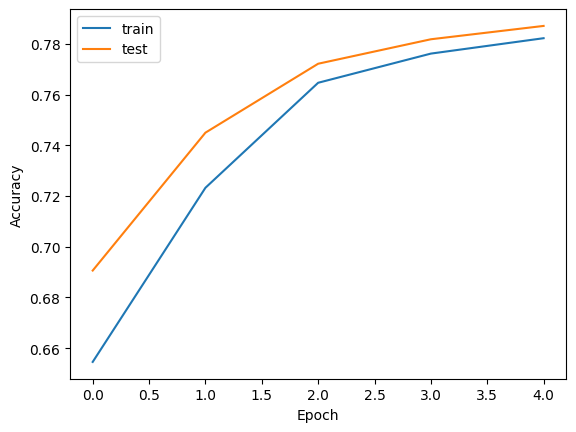

0.7870289219982471

In [10]:
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import matplotlib.pylab as plt
import numpy as np
import optuna
from optuna.exceptions import TrialPruned

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def test_accuracy(model, dl):
  acc = 0
  count = 0
  for x, y in dl:
    y_pred = model(x.to(device))
    y_pred = y_pred.argmax(dim=-1).cpu().numpy()
    acc += accuracy_score(y, y_pred) * len(y)
    count += len(y)
  return acc / count

def train(model: Model, epochs, ds,
          minibatch_size=1024,
          initial_lr=1e-3,
          verbose=True,
          trial: optuna.Trial=None,
  ):
  optimizer = torch.optim.Adam(model.parameters(), initial_lr)
  loss_fn = nn.CrossEntropyLoss()
  accs = []
  test_accs = []

  dl = DataLoader(ds, minibatch_size, shuffle=True,
                num_workers=4,
                pin_memory=torch.cuda.is_available())

  test_dl = DataLoader(test_ds, 512,
                      num_workers=3,
                      pin_memory=torch.cuda.is_available())

  for epoch in range(epochs):
    anneal_frac = 1.0 - epoch / epochs
    lr = initial_lr * anneal_frac
    optimizer.param_groups[0]["lr"] = lr

    model.train()

    minibatches = 0
    total_loss = 0
    total_acc = 0
    for x, y in dl:
      optimizer.zero_grad()
      y_pred = model(x.to(device))
      loss = loss_fn(y_pred, y.to(device))
      loss.backward()
      optimizer.step()

      total_loss += loss.item()
      y_pred = y_pred.argmax(dim=-1)
      total_acc += accuracy_score(y, y_pred.cpu().numpy())
      minibatches += 1

    model.eval()
    epoch_loss = total_loss / minibatches
    with torch.no_grad():
      test_acc = test_accuracy(model, test_dl)
    acc = total_acc / minibatches

    if trial is not None:
      trial.report(test_acc, epoch)
      if trial.should_prune() and epoch > 10:
        raise TrialPruned()

    accs.append(acc)
    test_accs.append(test_acc)

    if verbose:
      print("epoch:", epoch+1, "loss:", epoch_loss, "lr:", lr)
      print("acc:", acc, "test acc:", test_acc)

  if verbose:
    plt.plot(np.arange(len(accs)), accs, label='train')
    plt.plot(np.arange(len(test_accs)), test_accs, label='test')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

  return test_acc

model = Model().to(device)
train(model, 5, train_ds)

### Hyperparameter Tuning

For this exercise, we have decided to use optuna to do a full sweep
of hyperparameter configurations. This dataset and model are rather small,
so we are able to perform a rather thorough hyperparameter seach rather quickly.

We allow all of our model HPs to be searched, although we do limit
layer sizes to powers of two for efficiency. 

We begin the search, and optuna will present us with its findings, as well
as record them to a local SQLite database.

In [11]:
from optuna import create_study

def objective(trial: optuna.Trial):
  encoder_size = trial.suggest_categorical("encoder_size", [64, 128])
  hidden_size = trial.suggest_categorical("hidden_size", [128, 256, 512])
  num_rnn_layers = trial.suggest_int("num_rnn_layers", 1, 4)
  rnn_dropout = trial.suggest_float("rnn_dropout", 0.05, 0.4) if num_rnn_layers > 1 else 0
  use_gru = trial.suggest_categorical("use_gru", [True, False])
  classifier_dropout = trial.suggest_float("classifier_dropout", 0.1, 0.8)

  classifier_num_layers = trial.suggest_int("classifier_num_layers", 1, 4)
  classifier_arch = []
  for i in range(classifier_num_layers):
    size = trial.suggest_categorical(f'classifier_arch_{i}', [128, 256, 512])
    classifier_arch.append(size)

  model = Model(
    encoder_size=encoder_size,
    hidden_size=hidden_size,
    num_rnn_layers=num_rnn_layers,
    rnn_dropout=rnn_dropout,
    use_gru=use_gru,
    classifier_arch=classifier_arch,
    classifier_dropout=classifier_dropout,
  ).to(device)

  return train(model, 25, train_ds, verbose=False, trial=trial)

study = create_study(direction="maximize", storage="sqlite:///nlp-getting-started.db",
                     load_if_exists=True, study_name="study5")
study.optimize(objective, n_trials=50, show_progress_bar=True)

[I 2024-11-01 10:34:27,233] A new study created in RDB with name: study5


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-11-01 10:35:06,151] Trial 0 finished with value: 0.803680981595092 and parameters: {'encoder_size': 128, 'hidden_size': 512, 'num_rnn_layers': 3, 'rnn_dropout': 0.052181972970182844, 'use_gru': True, 'classifier_dropout': 0.3275998867223777, 'classifier_num_layers': 1, 'classifier_arch_0': 256}. Best is trial 0 with value: 0.803680981595092.
[I 2024-11-01 10:35:25,087] Trial 1 finished with value: 0.8089395267309377 and parameters: {'encoder_size': 64, 'hidden_size': 256, 'num_rnn_layers': 3, 'rnn_dropout': 0.39586368745476364, 'use_gru': True, 'classifier_dropout': 0.18915386712200832, 'classifier_num_layers': 2, 'classifier_arch_0': 128, 'classifier_arch_1': 128}. Best is trial 1 with value: 0.8089395267309377.
[I 2024-11-01 10:35:44,690] Trial 2 finished with value: 0.8098159509202454 and parameters: {'encoder_size': 128, 'hidden_size': 512, 'num_rnn_layers': 1, 'use_gru': False, 'classifier_dropout': 0.5196634153808454, 'classifier_num_layers': 1, 'classifier_arch_0': 512}.

Now that the training is complete, we report the optuna findings below.

There does not seem to be a very diverse set of hyperparameter strengths, with our
classifier dropout and RNN size being the most important parameters.

/tmp/ipykernel_2475366/3561115928.py:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig1 = plot_optimization_history(study)
/tmp/ipykernel_2475366/3561115928.py:4: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  fig2 = plot_param_importances(study)


AttributeError: 'Axes' object has no attribute 'show'

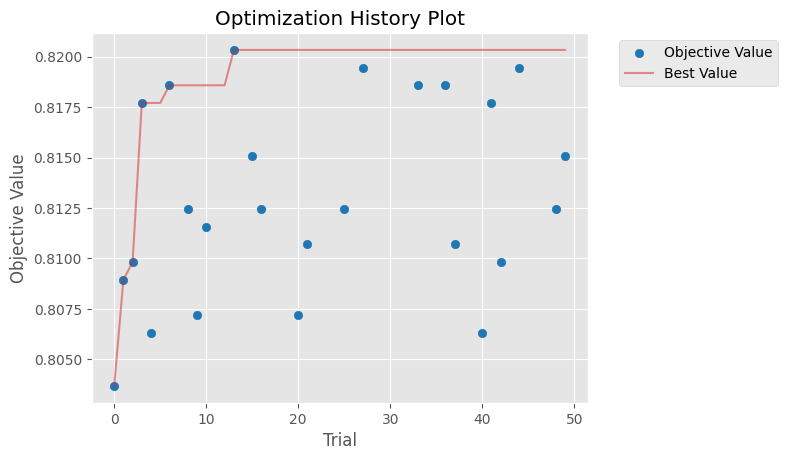

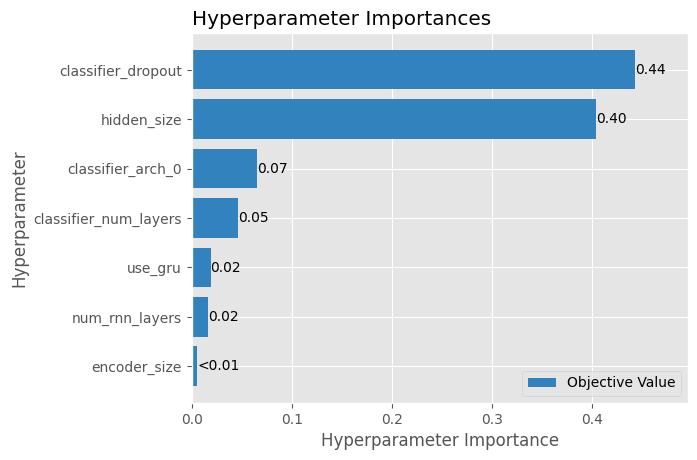

In [ ]:
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances

fig1 = plot_optimization_history(study)
fig2 = plot_param_importances(study)

#best
#[I 2024-11-01 10:40:11,702] Trial 13 finished with value: 0.820333041191937 and parameters: {'encoder_size': 128, 'hidden_size': 128, 'num_rnn_layers': 2, 'rnn_dropout': 0.31633315750327806, 'use_gru': True, 'classifier_dropout': 0.7330714420178419, 'classifier_num_layers': 2, 'classifier_arch_0': 512, 'classifier_arch_1': 512}. Best is trial 13 with value: 0.820333041191937.

fig1.show()
fig2.show()

### Training

Given that only two of our parameters have strong important, we're able to look
through the other trials that completed to pick the remaining hyperparameters
based on what will keep the model small. 

Our final selection of HPs are loaded into our model, and we start our first 
full training session on our training data.

Our accuracy data reports that are test validation does plateua rather quickly,
but does not regress in accuracy which is a good sign that we are not overfitting
with this number of epochs.

epoch: 1 loss: 0.7276685578482491 lr: 0.001
acc: 0.5466334113675958 test acc: 0.5661700262927257
epoch: 2 loss: 0.6183468954903739 lr: 0.0009666666666666667
acc: 0.6603195775261324 test acc: 0.7204206836108676
epoch: 3 loss: 0.5283168894904 lr: 0.0009333333333333333
acc: 0.7482204104965157 test acc: 0.7537248028045574
epoch: 4 loss: 0.498054815190179 lr: 0.0009000000000000001
acc: 0.7717259636324042 test acc: 0.7747589833479404
epoch: 5 loss: 0.4743900043623788 lr: 0.0008666666666666667
acc: 0.7854216572299652 test acc: 0.7870289219982471
epoch: 6 loss: 0.45175245829990934 lr: 0.0008333333333333334
acc: 0.8020096091027875 test acc: 0.7931638913234005
epoch: 7 loss: 0.4450181637491499 lr: 0.0008
acc: 0.8033196319686411 test acc: 0.7835232252410167
epoch: 8 loss: 0.43868289249283926 lr: 0.0007666666666666666
acc: 0.8017680204703833 test acc: 0.7975460122699386
epoch: 9 loss: 0.4261172115802765 lr: 0.0007333333333333334
acc: 0.8127824205139372 test acc: 0.8028045574057844
epoch: 10 loss: 

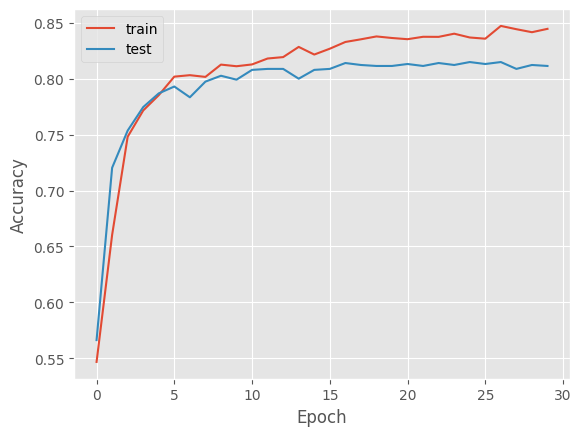

0.8115687992988606

In [28]:
model = Model(encoder_size=128, hidden_size=128, num_rnn_layers=3,
              rnn_dropout=0.3, classifier_arch=[512], classifier_dropout=0.6).to(device)

train(model, 30, train_ds)

### Fine Tuning

We've decided to fine-tune the model on the total available dataset, as our final
submission will be based on a set of unlabeled data anyways. We've observed that we
are not at much risk of overfitting, but we still conservatively chose a low number
of epochs to train with the full data, in this case just 5 epochs.

epoch: 1 loss: 0.4525023326277733 lr: 0.001
acc: 0.8066178568293539 test acc: 0.7808939526730938
epoch: 2 loss: 0.41558800265192986 lr: 0.0008
acc: 0.819922149315309 test acc: 0.8194566170026293
epoch: 3 loss: 0.38278114423155785 lr: 0.0006
acc: 0.8415063750877809 test acc: 0.8255915863277826
epoch: 4 loss: 0.3683721646666527 lr: 0.0004
acc: 0.8450713768433988 test acc: 0.8334794040315513
epoch: 5 loss: 0.3642542362213135 lr: 0.00019999999999999996
acc: 0.8479892687851124 test acc: 0.8334794040315513


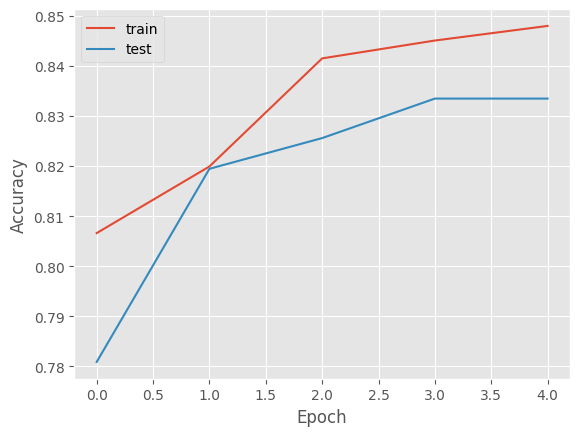

0.8334794040315513

In [32]:
train(model, 5, full_ds)

## Submission

Now that our model is ready, we process and label the `test` submission for Kaggle.
Once all labels are produced, we save them to a CSV that we can upload to the Kaggle site.

In [41]:
df = pd.read_csv(base_path + 'test.csv')

df.info()
df.head()

del df['keyword']
del df['location']
df['label'] = 0
df['tokens'] = df.text.apply(tokenize)

submit_ds = TextDataset(df)
submit_dl = DataLoader(submit_ds, 512,
                      num_workers=2,
                      pin_memory=torch.cuda.is_available())

y_pred = []
for x, _ in submit_dl:
  y_pred_b: torch.Tensor = model(x.to(device))
  y_pred_b = y_pred_b.argmax(dim=-1).cpu().tolist()
  y_pred.extend(y_pred_b)

df['target'] = y_pred

del df['label']
del df['tokens']
del df['text']

display(df.sample(n=15))

df.to_csv(base_path + 'submission.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


,id,target
3093,10238,1
1418,4663,0
1985,6692,0
3181,10549,0
2610,8713,0
62,206,1
2403,8046,0
1327,4380,1
2305,7706,0
1568,5288,0


# Conclusion

Our Kaggle submission reports an 80% accuracy. This is not an extremely good score, but it is
fine with our given architecture and approach. The leaderboard shows several 100% submissions, but they quickly drop off into the 80% range. This is likely due to the limits of the provided dataset. There were not many examples to work off of, so it is unlikely that any model is able to produce
a solid understanding of the english language unless it has some to start with.

## Transfer Learning

The ideal way to go about this would be to use transfer learning from a model that already
has a thorough understanding of the english language. This is a common approach in sentiment analysis
and many other NLP problems, as the existing models can contain a deep and useful understanding
of langauge that can allow them to accomplsh language tasks on smaller datasets
very well.

## RNNs
RNNs were the state-of-the-art for language processing tasks for a long time before
the Transformer architecture came to be. Transformers can offer a much more expressive 
understanding of langauge over longer sequences, and don't suffer from the same gradient
issues as RNN based NLP models. 

There are several models available, especially through
HuggingFace's Transformers library, that allow you to import prebuild transformer
models that are likely to be much better at this task than a from-scratch model.